# Correct CASSIE SDS timeseries for wave run-up (and set-up)
Following the formulas by Stockdon, Hilary F., Rob A. Holman, Peter A. Howd, and Asbury H. Sallenger. “Empirical Parameterization of Setup, Swash, and Runup.” Coastal Engineering 53, no. 7 (May 1, 2006): 573–88. https://doi.org/10.1016/j.coastaleng.2005.12.005.

In [1]:
# Fill in your datapaths
main_datapath_input = '/home/bene/PhD-docs/80_papers/1_dataset_combination/data/input/'
main_datapath_output = '/home/bene/PhD-docs/80_papers/1_dataset_combination/data/output/'

## Imports

In [2]:
%load_ext autoreload
%autoreload 2
import statistics
import numpy as np
import xarray as xr
import os
import pickle
import pandas as pd

# plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
from cartopy.feature import LAND

# toolboxes
from coastal_data import CD_statistics, CD_helper_functions

import pdb

## Load CASSIE file

In [3]:
cd_cassie_tidalcorr_sm = pickle.load(open(main_datapath_output + 'cd_cassie_tcorr.pkl', 'rb'))
sl_cassie_red_tides = pickle.load(open(main_datapath_output + 'sl_cassie_red_tides.pkl', 'rb')) # only needed for dates
beach_slope_cassie = pickle.load(open(main_datapath_output + 'beach_slope_cassie.pkl', 'rb'))

## ERA5 SWH and peak wave period

In [4]:
path = '/media/bene/Seagate/PhD-data/17_SWH/2_ERA5/'
fn = 'era5_swh_pwp_combined.nc'
wave_data = xr.open_dataset(path + fn)

/tmp/ipykernel_25088/3476803514.py:1: RuntimeWarning: Mean of empty slice
  swh_temp_mean = np.nanmean(wave_data.swh, axis=0)


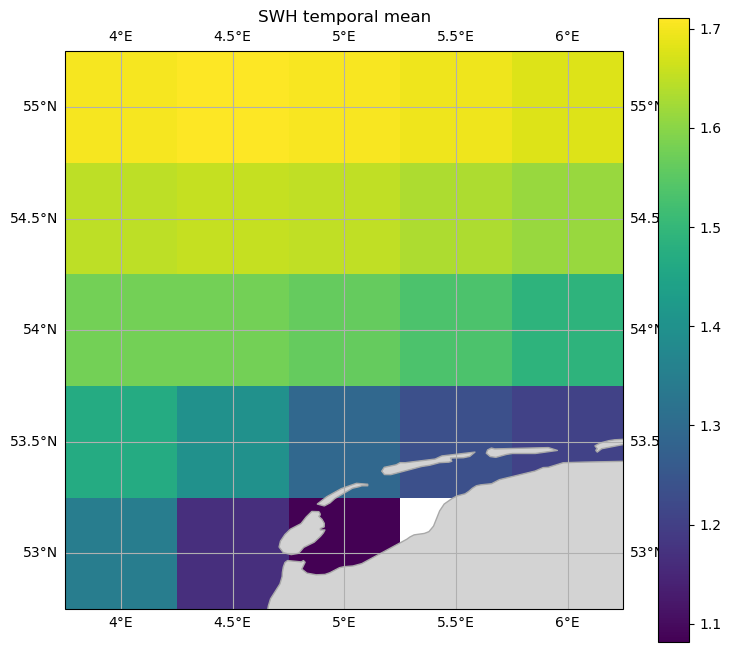

In [5]:
swh_temp_mean = np.nanmean(wave_data.swh, axis=0)
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
ax.add_feature(LAND, edgecolor = 'darkgray', facecolor = "lightgray", zorder=2)
plot = ax.pcolormesh(wave_data.longitude.values, wave_data.latitude.values, swh_temp_mean, transform=ccrs.PlateCarree())
plt.colorbar(plot, shrink=0.9)
ax.set_title("SWH temporal mean");

In [6]:
# Further reduce the area, use only the two values around Terschelling
wave_data_red = wave_data.sel(longitude=[5, 5.5], latitude=53.5)

# Spatially average swh and pwp
swh = wave_data_red.swh.mean(axis=1) # Significant wave height
pwp = wave_data_red.pp1d.mean(axis=1) # Peak wave period

dates_cassie = CD_helper_functions.datetime_to_decimal_numbers(pd.to_datetime(sl_cassie_red_tides['dates']))
dates_waves = CD_helper_functions.datetime_to_decimal_numbers(pd.to_datetime(wave_data_red.time))

# Interpolate swh and pwp onto times of image aqcuisition
swh_at_cassie_times = np.interp(dates_cassie, dates_waves, swh)
pwp_at_cassie_times = np.interp(dates_cassie, dates_waves, pwp)

## Wave run-up and wave set-up correction

In [7]:
# compute wave run-up / wave set-up
H = swh_at_cassie_times # Significant wave height in [m]
T = pwp_at_cassie_times # Peak wave period in [seconds]
g = 9.81 # Gravitational acceleration in [m/s**2]
L = (g * T ** 2) / (2*np.pi)

thresh_pos = 50 # [m] threshold the corrections to eliminate outliers
thresh_neg = -thresh_pos

setupcorr = {}
cd_setupcorr = {}
runupcorr = {}
cd_runupcorr = {}

for key in cd_cassie_tidalcorr_sm.keys():
    m = beach_slope_cassie[key]
    xi = m/np.sqrt(H / L)

    # wave set-up
    C = 0.3 # Arbitrary constant between 0.15 – 0.4
    eta = C * H * xi # formula 3, "popular formula"
    delta_x = eta / m
    delta_x[delta_x > thresh_pos] = thresh_pos
    delta_x[delta_x < thresh_neg] = thresh_neg
    setupcorr[key] = delta_x
    cd_setupcorr[key] = cd_cassie_tidalcorr_sm[key] - delta_x

    # wave run-up
    if np.nanmax(np.abs(xi)) < 0.3:
        R2 = 0.043 * np.sqrt(H * L)
        # Horizontal shift
        delta_x = R2 / m

        # Restrict to threshold
        delta_x[delta_x > thresh_pos] = thresh_pos
        delta_x[delta_x < thresh_neg] = thresh_neg
        
        runupcorr[key] = delta_x            
        cd_runupcorr[key] = cd_cassie_tidalcorr_sm[key] - delta_x
    else:
        eta = 0.3 * H * xi # wave set-up
        s_w = 0.75 * H * xi # swash uprush related to incident waves
        s_ig = 0.06 * np.sqrt(H * L) # uprush related to infragravity waves
        R2 = 1.1 * (eta + 0.5 * np.sqrt(s_w **2 + s_ig **2))
        delta_x = R2 / m
        delta_x[delta_x > thresh_pos] = thresh_pos
        delta_x[delta_x < thresh_neg] = thresh_neg
        
        runupcorr[key] = delta_x        
        cd_runupcorr[key] = cd_cassie_tidalcorr_sm[key] - delta_x

/tmp/ipykernel_25088/3269484971.py:22: RuntimeWarning: invalid value encountered in divide
  delta_x = eta / m
/tmp/ipykernel_25088/3269484971.py:45: RuntimeWarning: divide by zero encountered in divide
  delta_x = R2 / m
/tmp/ipykernel_25088/3269484971.py:32: RuntimeWarning: divide by zero encountered in divide
  delta_x = R2 / m
/tmp/ipykernel_25088/3269484971.py:29: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(np.abs(xi)) < 0.3:


### Wave run-up

In [8]:
# Median correction
all_corr = np.empty(0)
for key in runupcorr.keys():
    all_corr = np.hstack([all_corr, runupcorr[key]])

print('median:', round(np.nanmedian(all_corr),2), 'min:', np.nanmin(all_corr), 'max:', np.nanmax(all_corr))

median: -15.06 min: -50.0 max: 50.0


/tmp/ipykernel_25088/2814192973.py:4: RuntimeWarning: All-NaN slice encountered
  med_corr.append(np.nanmedian(runupcorr[key]))


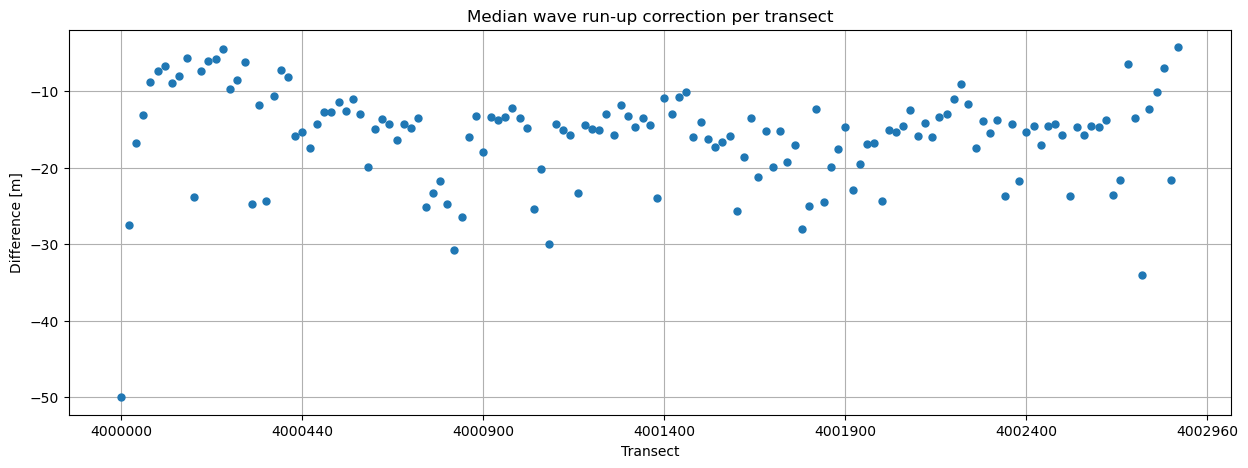

In [10]:
# Median correction per transect
med_corr = []
for key in runupcorr.keys():
    med_corr.append(np.nanmedian(runupcorr[key]))

fig, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(runupcorr.keys(), med_corr, '.', markersize=10,label='Wave run-up correction')
ax1.set_ylabel('Difference [m]')
ax1.set_xlabel('Transect')
xticks = list(runupcorr.keys())[0::25]
ax1.set_xticks(xticks)
ax1.grid()
ax1.set_title('Median wave run-up correction per transect');

In [13]:
# std and trends, version only with tidal correction
std_tidalcorr = []
trend_tidalcorr = []
i = 0
for key in cd_cassie_tidalcorr_sm.keys():
    ts = cd_cassie_tidalcorr_sm[key]
    if np.all(np.isnan(ts)):
        std_tidalcorr.append(np.nan)
        trend_tidalcorr.append(np.nan)
        continue
    ts_nonan = ts[~np.isnan(ts)]
    std_tidalcorr.append(statistics.stdev(ts_nonan))
    trend_tidalcorr.append(CD_statistics.compute_trend(dates_cassie, ts))
    
print('std [m], only tidal correction')
print('median:', round(np.nanmedian(std_tidalcorr),2), 'mean:', round(np.nanmean(std_tidalcorr),2),
      'min:', round(np.nanmin(std_tidalcorr),2), 'max:', round(np.nanmax(std_tidalcorr),2))
print('\n', 'trend [m/year], only trend_tidalcorr correction')
print('median:', round(np.nanmedian(trend_tidalcorr),2), 'mean:', round(np.nanmean(trend_tidalcorr),2),
      'min:', round(np.nanmin(trend_tidalcorr),2), 'max:', round(np.nanmax(trend_tidalcorr),2))

std [m], only tidal correction
median: 82.16 mean: 101.1 min: 39.93 max: 422.38

 trend [m/year], only trend_tidalcorr correction
median: -0.1 mean: -2.09 min: -42.16 max: 14.72


In [23]:
# std and trends, adding additionally wave run-up correction
def std_trend_wavecorr(cd_wavecorr, std_tidalcorr, trend_tidalcorr, run_or_set):
    std_wavecorr = []
    trend_wavecorr = []
    for key in cd_wavecorr.keys():
        ts = cd_wavecorr[key]
        if np.all(np.isnan(ts)):
            std_wavecorr.append(np.nan)
            trend_wavecorr.append(np.nan)
            continue
        ts_nonan = ts[~np.isnan(ts)]
        std_wavecorr.append(statistics.stdev(ts_nonan))
        trend_wavecorr.append(CD_statistics.compute_trend(dates_cassie, ts))
    print('std [m], with wave run-up')
    print('median:', round(np.nanmedian(std_wavecorr),2), 'mean:', round(np.nanmean(std_wavecorr),2),
          'min:', round(np.nanmin(std_wavecorr),2), 'max:', round(np.nanmax(std_wavecorr),2))
    print('\n', 'trend [m/year], with wave run-up')
    print('median:', round(np.nanmedian(trend_wavecorr),2), 'mean:', round(np.nanmean(trend_wavecorr),2),
          'min:', round(np.nanmin(trend_wavecorr),2), 'max:', round(np.nanmax(trend_wavecorr),2))
    
    fig, ax = plt.subplots(figsize=(13,4))
    ax.plot(cd_wavecorr.keys(), trend_tidalcorr, '.-', label='tidal corr')
    ax.plot(cd_wavecorr.keys(), trend_wavecorr, '.-', label='+ wave corr')
    ax.legend()
    xticks = list(cd_wavecorr.keys())[0::25]
    ax.set_xticks(xticks)
    ax.set_xlabel('Transect')
    ax.set_ylabel('Trend [m/year]')
    ax.set_title('Influence of wave '+ run_or_set +'-up correction on trend')
    ax.grid()
    
    fig, ax = plt.subplots(figsize=(13,4))
    ax.plot(cd_wavecorr.keys(), std_tidalcorr, '.-', label='tidal corr')
    ax.plot(cd_wavecorr.keys(), std_wavecorr, '.-', label='+ wave corr')
    ax.legend()
    xticks = list(cd_wavecorr.keys())[0::25]
    ax.set_xticks(xticks)
    ax.set_xlabel('Transect')
    ax.set_ylabel('Std [m]')
    ax.set_title('Influence of wave '+ run_or_set +'-up correction on standard deviation')
    ax.grid()

std [m], with wave run-up
median: 85.51 mean: 102.84 min: 43.41 max: 427.59

 trend [m/year], with wave run-up
median: -0.07 mean: -2.25 min: -42.6 max: 13.06


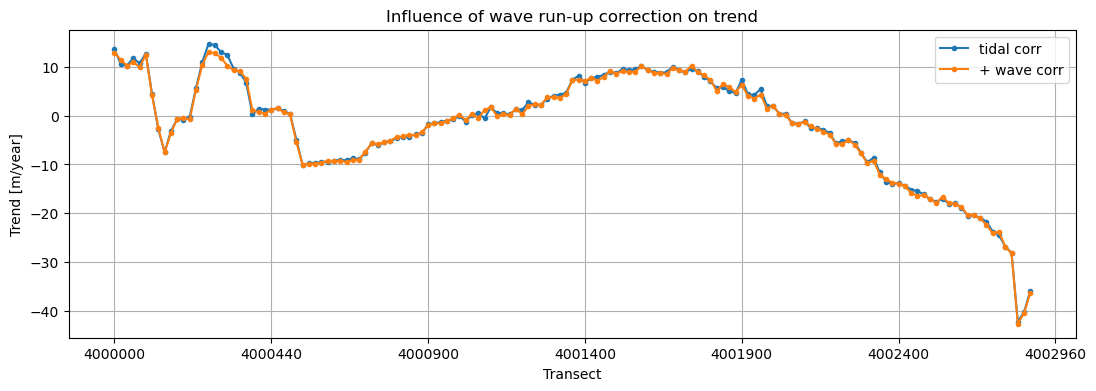

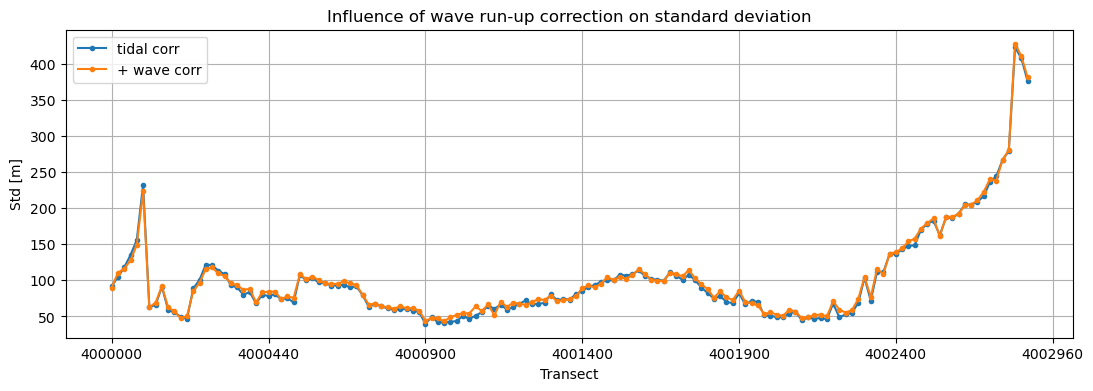

In [24]:
std_trend_wavecorr(cd_runupcorr, std_tidalcorr, trend_tidalcorr, run_or_set='run')

### Wave set-up

In [25]:
# Median correction
all_corr = np.empty(0)
for key in runupcorr.keys():
    all_corr = np.hstack([all_corr, setupcorr[key]])

print('median:', round(np.nanmedian(all_corr),2), 'min:', np.nanmin(all_corr), 'max:', np.nanmax(all_corr))

median: 1.96 min: 0.5569073157524778 max: 6.9017103029876


/tmp/ipykernel_25088/401393142.py:4: RuntimeWarning: All-NaN slice encountered
  med_corr.append(np.nanmedian(setupcorr[key]))


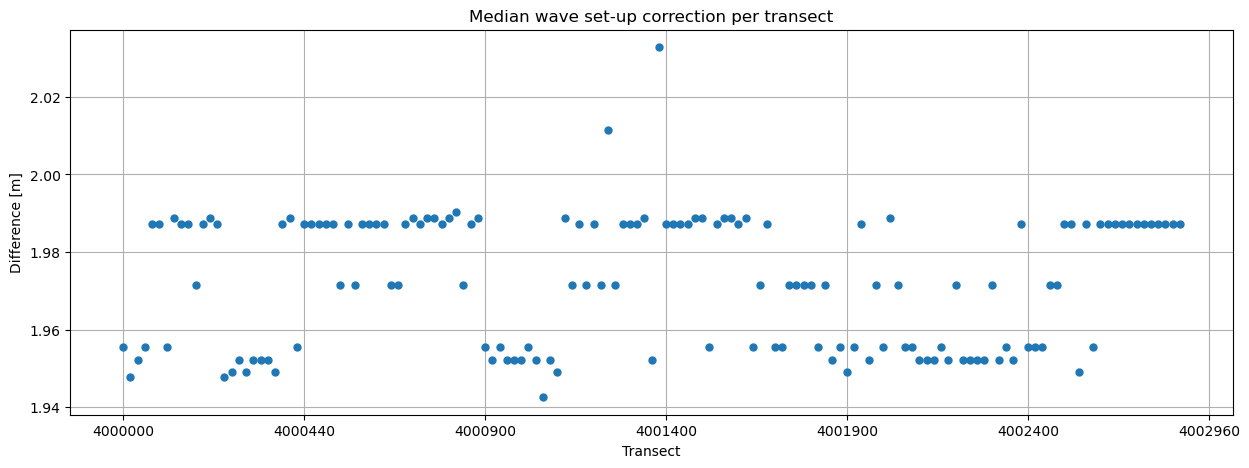

In [27]:
# Median correction per transect
med_corr = []
for key in setupcorr.keys():
    med_corr.append(np.nanmedian(setupcorr[key]))

fig, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(runupcorr.keys(), med_corr, '.', markersize=10)
ax1.set_ylabel('Difference [m]')
ax1.set_xlabel('Transect')
xticks = list(runupcorr.keys())[0::25]
ax1.set_xticks(xticks)
ax1.grid()
ax1.set_title('Median wave set-up correction per transect');

std [m], with wave run-up
median: 82.21 mean: 100.84 min: 40.0 max: 422.39

 trend [m/year], with wave run-up
median: -0.07 mean: -2.11 min: -42.16 max: 14.46


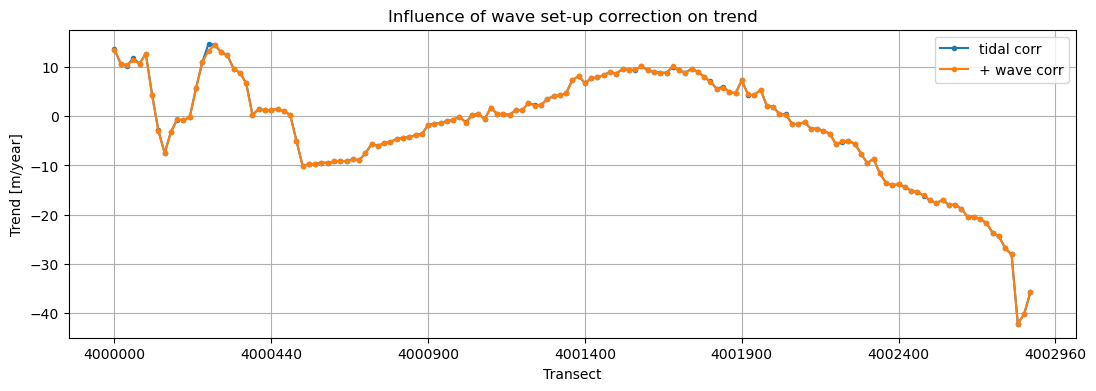

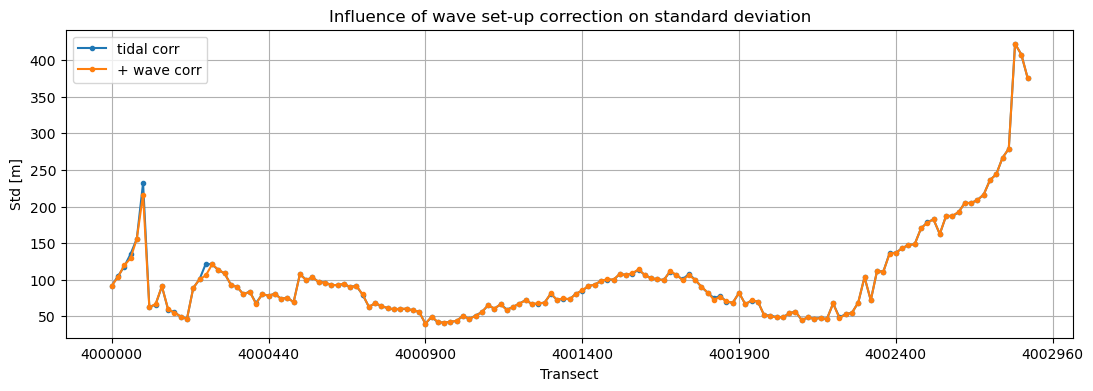

In [28]:
std_trend_wavecorr(cd_setupcorr, std_tidalcorr, trend_tidalcorr, run_or_set='set')